# Estrategia de Pricing y Rentabilidad: Car Rental 2025
### Análisis de gestión de ingresos y optimización de flotas

**Analista:** Julio Lagos  
**Stack Técnico:** `Python` | `SQL (SQLite3)` | `Pandas` | `Seaborn` | `Matplotlib`

---

##  Resumen
Este análisis audita la estrategia de precios y gestión de flota de un car rental durante el año 2025. A pesar de mantener una ocupación saludable (70-80%), se han identificado ineficiencias críticas en la política de descuentos y gestión de inventario.

### Hallazgos Principales
* **Canibalización de Margen:** El multiplicador de temporada baja (0.80) sostiene la ocupación al reducir precios, pero a costa de sacrificar rentabilidad., llevando el RevPAR de vehículos económicos a niveles críticos de **<$2 USD/día**.
* **Escasez Crítica Generalizada:** Se detectaron cuellos de botella mensuales, destacando **Abril (Camionetas)** y **Julio (Económicos)** con 12 días de inventario agotado, lo que indica una pérdida sistemática de clientes de última hora.


### Recomendaciones Top
1. **Eliminar el multiplicador de 0.80** y establecer un "Precio Base Mínimo" para proteger la rentabilidad operativa.
2. **Implementar Tarifas Dinámicas:** Activar incrementos automáticos del 10-15% cuando la disponibilidad de una categoría baje del 15%.
3. **Ajuste de Flota:** Priorizar la expansión o el *pricing* premium en el segmento de Camionetas, dada su escasez persistente durante todo el año.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Conexion
conn = sqlite3.connect('rent_of_carv1.db')
df = pd.read_sql_query("SELECT * FROM reporte_tarifas", conn)
conn.close()

# Preparación de métricas base
df['pct_ocupacion'] = (df['ocupacion_del_dia'] / df['capacidad_total']) * 100
orden_meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 
               'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']
df['mes'] = pd.Categorical(df['mes'], categories=orden_meses, ordered=True)

# Estilo global para los gráficos
sns.set_style("whitegrid")
sns.set_palette("muted")
color_barras = "#2c3e50" # azul petróleo
color_linea  = "#e74c3c" # rojo carmesí

### 1. Desempeño Mensual: Ingresos y Ocupación
En esta sección analizamos la salud general del negocio. El objetivo es observar si los incrementos en la ocupación se traducen efectivamente en mayores ingresos, validando así nuestra estrategia estacional.

C:\Users\User\AppData\Local\Temp\ipykernel_22268\913498043.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(orden_meses, rotation=45)


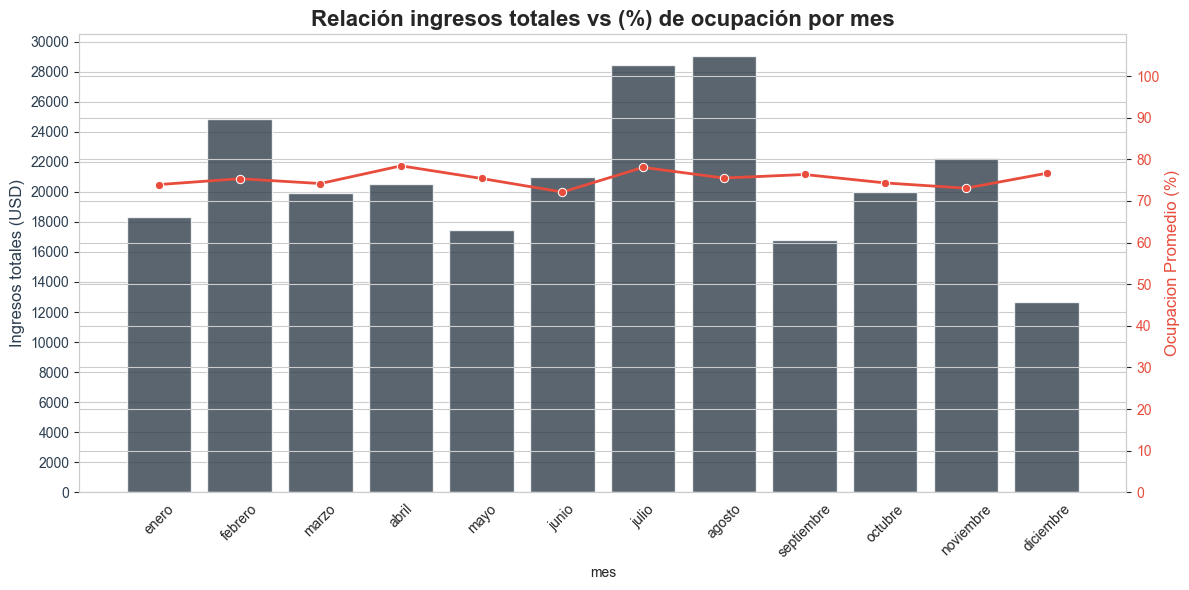

In [6]:
resumen_mensual = df.groupby(['mes'], observed=True).agg({
    'precio_final': 'sum',
    'pct_ocupacion': 'mean',
}).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Barras de ingresos
sns.barplot(data=resumen_mensual, x='mes', y='precio_final', 
            color=color_barras, ax=ax1, alpha=0.8) 
ax1.set_ylabel('Ingresos totales (USD)', color=color_barras, fontsize=12)
ax1.set_yticks(range(0, int(resumen_mensual['precio_final'].max())+2000, 2000))
ax1.tick_params(axis='y', labelcolor=color_barras)

# Ocupación %
ax2 = ax1.twinx()
sns.lineplot(data=resumen_mensual, x='mes', y='pct_ocupacion', 
             marker='o', color=color_linea, ax=ax2, linewidth=2)
ax2.set_ylabel('Ocupacion Promedio (%)', color=color_linea, fontsize=12)
ax2.set_ylim(0, 110)
ax2.set_yticks(range(0, 110, 10))
ax2.tick_params(axis='y', labelcolor=color_linea)

plt.title('Relación ingresos totales vs (%) de ocupación por mes', fontsize=16, fontweight='bold')
ax1.set_xticklabels(orden_meses, rotation=45)
plt.tight_layout()
plt.show()

###  Análisis de Sensibilidad y Eficacia de Multiplicadores

Al comparar el volumen de ventas contra el uso de la flota, se identifica una oportunidad de optimización crítica en la estructura de precios.

#### **Observaciones Clave:**
* **Ocupación Estructuralmente Estable:** La flota mantiene una ocupación promedio de entre **70% y 80%** durante todo el año. Esto indica que la demanda es constante y saludable, independientemente de la temporada.
* **Brecha de Ingresos:** A pesar de tener una ocupación similar, existe una diferencia de más de **$10,000 USD** entre los meses pico (Julio/Agosto > $28k) y los meses valle (Mayo/Septiembre < $18k).

#### **Identificación del Problema (Causa Raíz):**
La estabilidad en la ocupación, incluso en meses de menores ingresos, refleja que la demanda se sostiene gracias a los ajustes de precios aplicados por temporada 
* El multiplicador de temporada baja (actualmente **0.80**) es demasiado agresivo. 
* Al aplicar un descuento automático del **20%**, estamos sacrificando margen de utilidad innecesariamente. Los datos demuestran que no necesitamos bajar tanto el precio para llenar la flota, ya que el mercado está dispuesto a alquilar al ritmo del 80% incluso en temporada baja.

#### **Recomendación Estratégica:**
**Optimizar el multiplicador de temporada baja, elevándolo de 0.80 a 0.90.** Esta acción permitiría capturar un mayor ingreso por cada unidad aprovechando la demanda orgánica existente, sin riesgo de dejar la flota ociosa (inventario parado).

### 2. Eficiencia por Unidad (RevPAR)


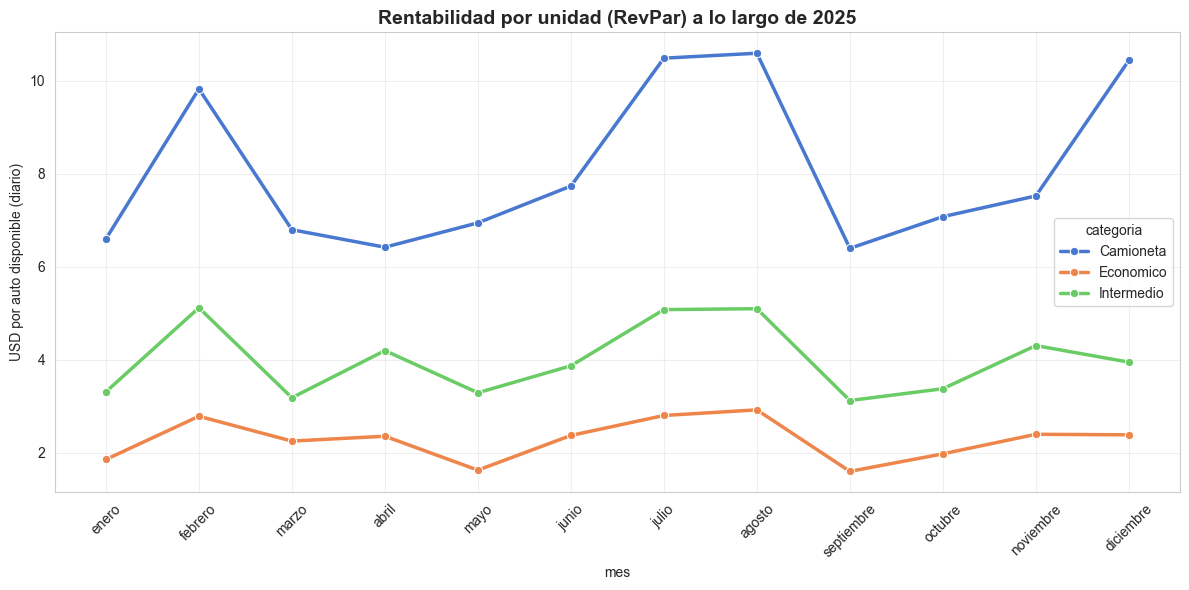

In [7]:
# Agrupamos por fecha y categoría para tener el ingreso diario real
daily_stats = df.groupby(['fecha_recogida', 'mes', 'categoria'], observed=True).agg({
    'precio_final': 'sum',
    'capacidad_total': 'max',
    'ocupacion_del_dia': 'max'
}).reset_index()

daily_stats['revpar_diario'] = daily_stats['precio_final'] / daily_stats['capacidad_total']
revpar_mensual = daily_stats.groupby(['mes', 'categoria'], observed=True)['revpar_diario'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=revpar_mensual, x='mes', y='revpar_diario', hue='categoria', marker='o', linewidth=2.5)
plt.title('Rentabilidad por unidad (RevPar) a lo largo de 2025', fontsize=14, fontweight='bold')
plt.ylabel('USD por auto disponible (diario)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Análisis de RevPAR: Rentabilidad por Unidad y Categoría

El RevPAR (Revenue Per Available Rental) nos permite ver cuánto dinero genera cada vehículo de la flota por día. A diferencia del ingreso total, esta métrica revela qué tan eficiente es cada categoría individualmente.

#### **Hallazgos Clave:**
* **Umbral Crítico en Económicos:** En los meses de enero, mayo y septiembre, el RevPAR de la categoría Económica cae por debajo de los **$2.00 USD**. Esto indica que, tras aplicar el multiplicador de temporada baja (0.80), el ingreso por unidad es marginal y podría no estar cubriendo los costos operativos diarios (mantenimiento, seguro, limpieza).
* **Intermedios en "Tierra de Nadie":** Con un RevPAR menor a **$4.00 USD** en gran parte del año, esta categoría no logra despegar. Su rendimiento sugiere que el cliente prefiere el ahorro del Económico o el espacio de la Camioneta, dejando al Intermedio con una rentabilidad estancada.
* **Dominio de las Camionetas (SUV):** Es la categoría más sólida, con picos de rentabilidad en febrero, julio, agosto y diciembre. Su resiliencia demuestra que es el activo más valioso del inventario para proteger el flujo de caja.

#### **Conclusión Técnica:**
La caída drástica del RevPAR en los meses valle confirma que el multiplicador de **0.80** está erosionando el valor de la flota. No estamos logrando una "economía de escala" donde el volumen compense el bajo precio; simplemente estamos operando con márgenes mínimos.

#### **Recomendación Estratégica:**
**Reevaluar el Límite de Descuento por Categoría:**
En lugar de un multiplicador de 0.80 parejo para todos, se recomienda establecer un **Precio Base Mínimo** (Price Floor) para las categorías Económica e Intermedia. El objetivo es asegurar que, independientemente de la temporada, el ingreso por día nunca baje de un umbral de rentabilidad operativa, evitando así "alquilar por alquilar".

### 3. Análisis de Inventario Agotado
Aquí identificamos los "cuellos de botella". Los puntos rojos representan días donde la demanda superó nuestra capacidad operativa (ocupación > 90%), señalando oportunidades perdidas para aplicar tarifas dinámicas por escasez.

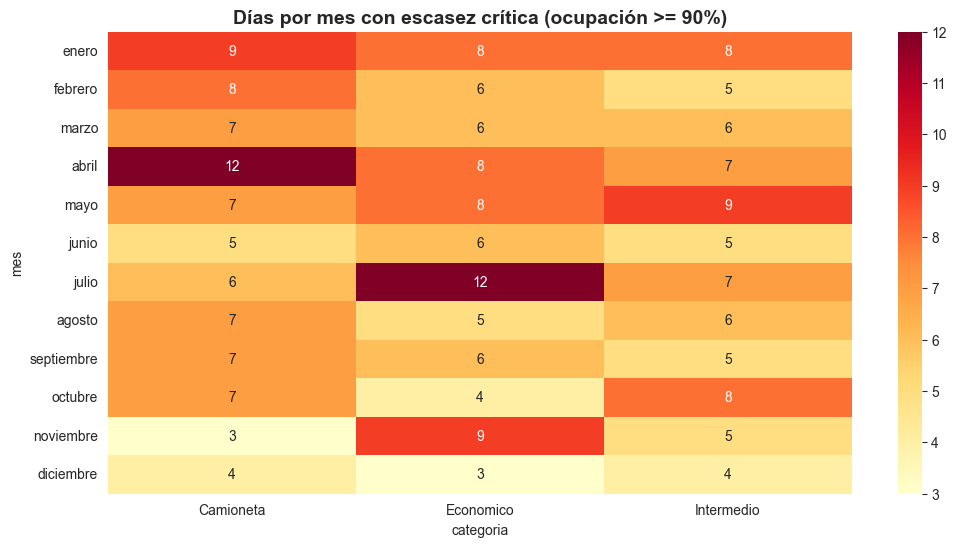

In [8]:
# Definimos escasez crítica
daily_stats['escasez_critica'] = daily_stats['ocupacion_del_dia'] >= (0.9 * daily_stats['capacidad_total'])
conteo_escasez = daily_stats[daily_stats['escasez_critica'] == True].groupby(['mes', 'categoria'], observed=True).size().unstack().fillna(0)

# Grafico mapa de calor
plt.figure(figsize=(12, 6))
sns.heatmap(conteo_escasez.reindex(orden_meses), annot=True, cmap='YlOrRd', fmt='g')
plt.title('Días por mes con escasez crítica (ocupación >= 90%)', fontsize=14, fontweight='bold')
plt.show()



### Mapa de Calor: Análisis de Escasez Crítica por Segmento

Este análisis detalla cómo se comporta la falta de inventario (ocupación >= 90%) en cada categoría. Los datos revelan que la escasez no es un problema de calendario, sino de estructura de flota y precios.

#### **Comportamiento por Categoría:**

* **Camionetas (SUV): El activo de mayor presión.**
    * **Pico Crítico:** Abril (12 días), seguido de enero (9) y febrero (8).
    * **Hallazgo:** Presenta escasez sostenida incluso en meses bajos (septiembre/octubre con 7 días). Esto sugiere que la demanda es estructuralmente alta; el inventario está subdimensionado para la demanda real del mercado.
* **Económicos: Sensibilidad Estacional.**
    * **Pico Crítico:** Julio (12 días), seguido de noviembre (9).
    * **Hallazgo:** La escasez es intermitente y ligada a meses de alta movilidad. Indica que el segmento tiene picos de presión, pero el inventario actual es suficiente para el resto del año.
* **Intermedio: Demanda Mal Calibrada.**
    * **Pico Crítico:** Mayo (9 días) y octubre (8).
    * **Hallazgo:** No presenta picos extremos, pero sí presión en meses "no convencionales". Esto refleja una oportunidad para optimizar el *pricing* o reposicionar su valor frente a las otras categorías.

#### **Hallazgos Estratégicos y Recomendaciones:**

1.  **Revisión Urgente de Camionetas:** Es necesario aumentar el inventario de esta categoría o, en su defecto, aplicar incrementos de precio agresivos todo el año, ya que la demanda no baja incluso en temporada baja.
2.  **Redistribución de Flota (Económicos):** Optimizar la disponibilidad en los meses pico detectados (Julio/Noviembre) para capturar el exceso de demanda.
3.  **Ajuste del Segmento Intermedio:** La demanda difusa en esta categoría sugiere que se podría usar como "comodín" de precios para capturar clientes que no alcanzan el precio de la SUV pero buscan más que un Económico.